# Classification

## MNIST

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

In [4]:
y.iloc[0]

'5'

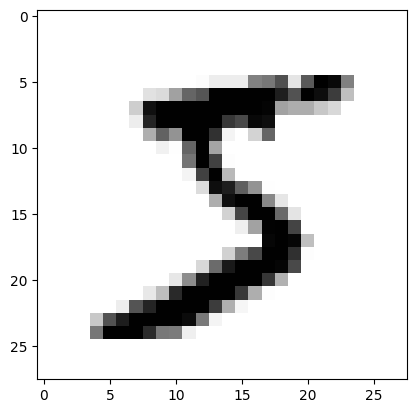

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl

some_digit = X.iloc[0].values.reshape(28, 28)
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.show()

In [6]:
some_digit[0][0]

np.int64(0)

In [7]:
import numpy as np
y = y.astype(np.uint8)

In [8]:
type(X), type(y)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
len(X_train), len(X_test), len(y_train), len(y_test)

(60000, 10000, 60000, 10000)

## Training a Binary Classifier

In [10]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
y_train_5.iloc[0], y_test_5.iloc[0]

(np.True_, np.False_)

In [11]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
some_digit = some_digit.reshape(1, -1)
sgd_clf.predict(some_digit)

/Users/samuel_paul_v/workspace/python/LittleMLThings/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

In [25]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

X (60000, 784) y (60000,)
train (40000,) test (20000,)
0.9669
X (60000, 784) y (60000,)
train (40000,) test (20000,)
0.91625
X (60000, 784) y (60000,)
train (40000,) test (20000,)
0.96785


In [23]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

### Confusion matrix

In [26]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [29]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

`53892` true negatives, `687` false positive, `1891` false negative and `3530` true positives.

In [30]:
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]])

The above represents the perfect match, with `0` false negative and false positives.

### Precision and Recall

* _Precision_ is the accuracy of the positive predictions.
* _Recall_ (a.k.a. _Sensitivity_) or the _True Positive Rate (*TPR*)_ is the ratio of positive instances that are correctly detected and the sum of True positives and False negatives.

`Precision = TP / (TP + FP)`

`Recall = TP / (TP + FN)`

![Illustration of Confusion Matrix](./img/confusion_matrix-illustration.png)

In [32]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)

(0.8370879772350012, 0.6511713705958311)

### F1 Score

`F1 score = 2 / (1/Precision + 1/Recall)`

`F1 score = TP / (TP + (FN + FP)/2)`

In [33]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

### Precision-Recall Trade-off

`SGDClassifier` makes its classification based on a score computed by a `decision function`.
If this score is greater than a threshold, it assigns the instance to the positive class; otherwise to the negative class. This threshold is illustrated below:

![Illustration of the decision fn threshold](img/decision_fn_threshold_in_classifier.png)

In [34]:
y_scores = sgd_clf.decision_function(some_digit)
y_scores

/Users/samuel_paul_v/workspace/python/LittleMLThings/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [40]:
threshold = 0
y_some_digit = y_scores > threshold
y_some_digit

array([ True])

`SGDClassifier` uses a threshold `0`, but a higher threshold decreases Recall.

In [41]:
threshold = 8000
y_some_digit = y_scores > threshold
y_some_digit

array([False])

#### Precision-Recall Curve

In [65]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [70]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center left', framealpha=0.25)

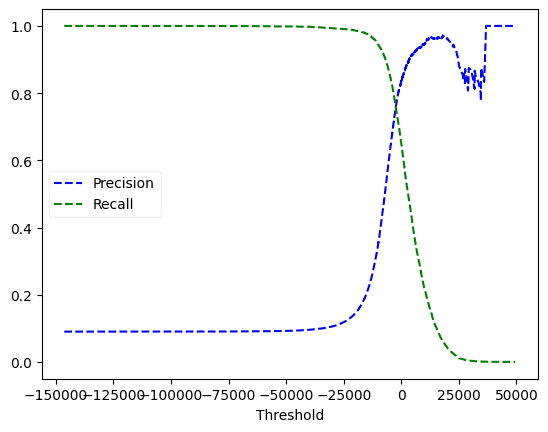

In [71]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [72]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_recall = thresholds[np.argmin(recalls >= 0.90)]
threshold_90_precision, threshold_90_recall

(np.float64(3370.0194991439594), np.float64(-6861.0325379402575))

### The ROC Curve

The *Receiver Operating Characteristics (ROC)* curve plots the `true positive rate (TPR)` against the `false positive rate (FPR)`.

In [73]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [74]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dash-line diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

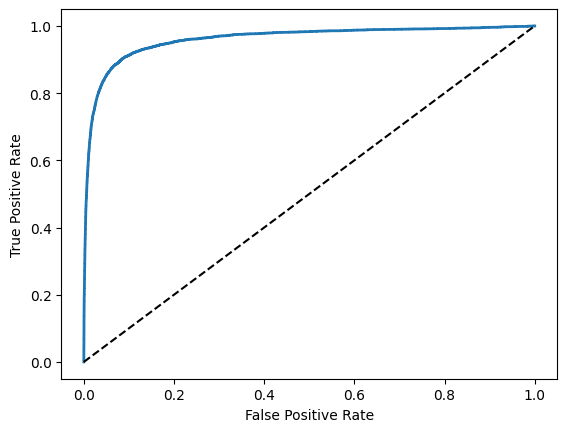

In [75]:
plot_roc_curve(fpr, tpr)
plt.show()

One way to compare classifiers is to measure the *ROC Area under the curve (AUC)*. A perfect classifier will have a *ROC AUC* as `1`, whereas a random classifier will have it as `0.5`.

In [76]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

#### ROC curve for `RandomForestClassifier`

Since Random Forest doesn't have a `decision function`, it exposes a `predict_proba()` method; which returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class.

In [77]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [78]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

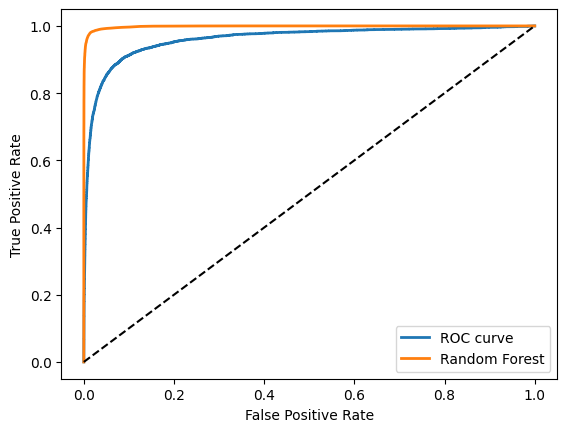

In [79]:
plt.plot(fpr, tpr, linewidth=2, label='ROC curve')
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc='lower right')
plt.show()

In [81]:
print('ROC AUC for RandomForest', roc_auc_score(y_train_5, y_scores_forest))
print('ROC AUC for GDClassifier', roc_auc_score(y_train_5, y_scores))

ROC AUC for RandomForest 0.9983436731328145
ROC AUC for GDClassifier 0.9604938554008616


The above demonstrates that there is `99%` precision when using Random Forest.

## Multiclass Classification

Some Algorithms such as the below are capable of handling multiple classes native:

* SGD Classifier,
* Random Forest Classifier,
* Naive Bayes Classifiers, etc.

While others are purely binary classifiers:

* Logistic Regression,
* Support Vector Machine Classifier, etc.

Though we can use Binary Classifiers with techniques like `One-vs-One Classification` and `One-vs-Rest Classification` for multi-class classification task.

Tyring out things with a *Support Vector Machine* classifier:

In [82]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train, y_train)
svm_clf.predict(some_digit)

/Users/samuel_paul_v/workspace/python/LittleMLThings/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

Under the hood, SVM uses 45 binary classifiers (in our case), and uses *OvO* (One-vs-One) strategy.

In [83]:
some_digit_scores = svm_clf.decision_function(some_digit)
some_digit_scores

/Users/samuel_paul_v/workspace/python/LittleMLThings/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [84]:
np.argmax(some_digit_scores)

np.int64(5)

In [85]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [86]:
svm_clf.classes_[np.argmax(some_digit_scores)]

np.uint8(5)

We can also use the *OvR* (One-vs-Rest) strategy for the SVM:

In [88]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC(random_state=42))

In [92]:
ovr_clf.predict(some_digit)

/Users/samuel_paul_v/workspace/python/LittleMLThings/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/samuel_paul_v/workspace/python/LittleMLThings/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/samuel_paul_v/workspace/python/LittleMLThings/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/samuel_paul_v/workspace/python/LittleMLThings/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/samuel_paul_v/workspace/python/LittleMLThings/.venv/lib/python3.12/site-packages/skle

array([5], dtype=uint8)

In [93]:
ovr_clf.estimators_

[SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42)]

In [94]:
len(ovr_clf.estimators_)

10

We can use `SGDClassifier` directly for Multi-class classification without the need for OvR or OvO strategy as SGD classifier natively supports multiple classes.

In [95]:
sgs_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict(some_digit)

/Users/samuel_paul_v/workspace/python/LittleMLThings/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([3], dtype=uint8)

In [96]:
sgd_clf.decision_function(some_digit)

/Users/samuel_paul_v/workspace/python/LittleMLThings/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [99]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgs_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

SGD Classifier got 87% accuracy on all test folds, but we can do much better.

### Use `Feature scaling` to increase accuracy on Classifiers

In [100]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgs_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

In [111]:
X_train_scaled[0][180:190]

array([0.74933951, 1.32200212, 1.19900231, 1.14748071, 1.16876765,
       1.25693737, 1.17313576, 0.93344155, 2.13777179, 2.64653072])

In [114]:
X_train.astype(np.float64).iloc[0][180:190].values

array([170., 253., 253., 253., 253., 253., 225., 172., 253., 242.])

## Error Analysis



In [115]:
y_train_pred = cross_val_predict(sgs_clf, X_train_scaled, y_train, cv=3)

array([[5731, 6564, 5608, 5540, 5483,  600, 5749, 5992, 7691, 5621],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])

In [118]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

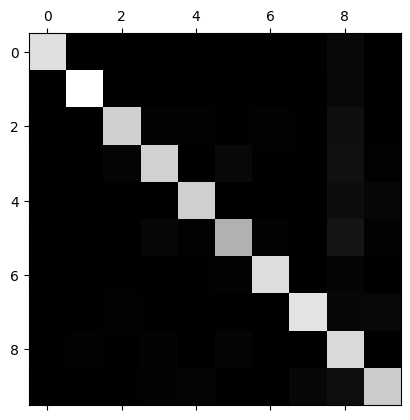

In [119]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Let's plot on the errors. First we divide each value in the confusion matrix by the number of images in the corresponding class so that we can compare error rates instead of absolute number of errors.

In [126]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [127]:
row_sums

array([[5923],
       [6742],
       [5958],
       [6131],
       [5842],
       [5421],
       [5918],
       [6265],
       [5851],
       [5949]])

In [128]:
norm_conf_mx

array([[9.41583657e-01, 0.00000000e+00, 3.71433395e-03, 8.44166807e-04,
        1.35066689e-03, 7.25983454e-03, 6.07800101e-03, 1.01300017e-03,
        3.79875063e-02, 1.68833361e-04],
       [0.00000000e+00, 9.49273213e-01, 5.48798576e-03, 3.55977455e-03,
        5.93295758e-04, 6.52625334e-03, 5.93295758e-04, 1.03826758e-03,
        3.14446752e-02, 1.48323939e-03],
       [4.53172205e-03, 4.53172205e-03, 8.76132931e-01, 1.54414233e-02,
        1.22524337e-02, 4.53172205e-03, 1.12453844e-02, 6.04229607e-03,
        6.34441088e-02, 1.84625713e-03],
       [3.58832164e-03, 2.77279400e-03, 1.90833469e-02, 8.52552602e-01,
        3.26211059e-04, 3.31104224e-02, 4.40384929e-03, 6.52422117e-03,
        6.57315283e-02, 1.19067036e-02],
       [2.05409106e-03, 2.39643958e-03, 7.01814447e-03, 1.54056830e-03,
        8.87024991e-01, 2.05409106e-03, 5.81992468e-03, 4.62170490e-03,
        5.93974666e-02, 2.80725779e-02],
       [4.98063088e-03, 2.76701716e-03, 5.53403431e-03, 3.09905921e-02,
   

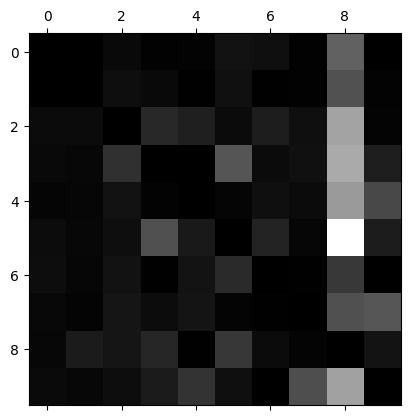

In [123]:
np.fill_diagonal(norm_conf_mx, 0) # fill the diagonal with zeroes to keep only errors
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

The column for class 8 is quite bright, which tells you that many images get misclassified as 8s. However row for class 8 is not that bad, telling you that actual 8s in general get properly classified as 8s.

Analyzing the confusion matrix often gives you insights into ways to improve your
classifier. Looking at this plot, it seems that your efforts should be spent on reducing
the false 8s.

In [134]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size, images_per_row * size)
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis('off')

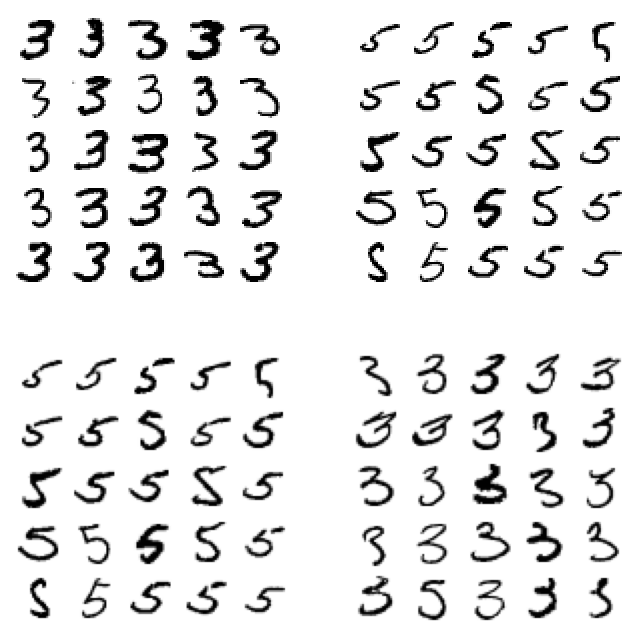

In [135]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
X_bb = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

The two 5 × 5 blocks on the left show digits classified as 3s, and the two 5 × 5 blocks
on the right show images classified as 5s. Some of the digits that the classifier gets
wrong (i.e., in the bottom-left and top-right blocks) are so badly written that even a
human would have trouble classifying them (e.g., the 5 in the first row and second
column truly looks like a badly written 3). However, most misclassified images seem
like obvious errors to us, and it’s hard to understand why the classifier made the mistakes
it did.3 The reason is that we used a simple SGDClassifier, which is a linear
model. All it does is assign a weight per class to each pixel, and when it sees a new
image it just sums up the weighted pixel intensities to get a score for each class. So
*since 3s and 5s differ only by a few pixels, this model will easily confuse them*.

## Multi-label Classification

When each instance can have multiple labels. E.g. a picture can recognise multiple people's faces in it.

In [136]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]], shape=(60000, 2))

In [137]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [138]:
knn_clf.predict(some_digit)

/Users/samuel_paul_v/workspace/python/LittleMLThings/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

Yes, digit 5 is indeed not large (`false`) and odd (`true`).

In [139]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [141]:
f1_score(y_train_knn_pred, y_multilabel, average='macro')

0.9764102655606048

## Multi-output Classification

Multi-output classification is a generalisation of multi-label classification where each label can be multi-class i.e. it can have more than two possible values.

In [143]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

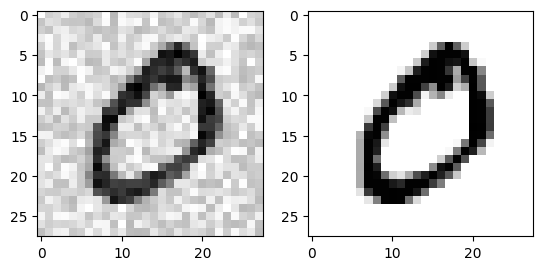

In [166]:
noise_digit = X_train_mod.iloc[1].values.reshape(28, 28)
noise_digit_image = noise_digit.reshape(28, 28)

digit = X_train.iloc[1].values.reshape(28, 28)
digit_image = digit.reshape(28, 28)

plt.subplot(1, 2, 1).imshow(noise_digit_image, cmap='binary')
# plt.subplot(111).title('Noise Digit')
plt.subplot(1, 2, 2).imshow(digit_image, cmap='binary')
# plt.subplot(112).title('Digit Image')
plt.show()

In [167]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

In [180]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary, interpolation='nearest')
    plt.axis('off')

/Users/samuel_paul_v/workspace/python/LittleMLThings/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


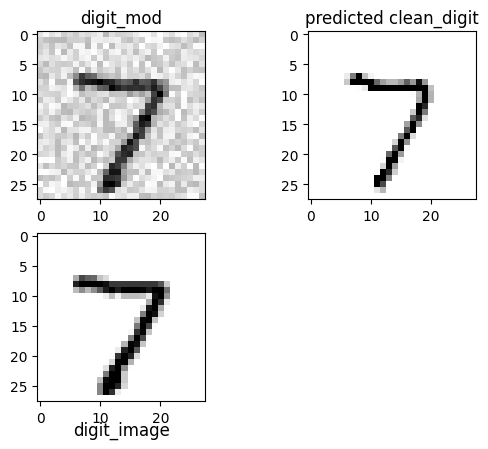

In [202]:
clean_digit = knn_clf.predict([X_test_mod.iloc[0]])
clean_digit = clean_digit.reshape(28, 28)
digit_mod = X_test_mod.iloc[0].values
digit_mod = digit_mod.reshape(28, 28)
digit = X_test.iloc[0].values
digit_image = digit.reshape(28, 28)

plt.subplot(2, 2, 1).imshow(digit_mod, cmap='binary')
plt.subplot(2, 2, 1).set_title('digit_mod')
plt.subplot(2, 2, 2).imshow(clean_digit, cmap='binary')
plt.subplot(2, 2, 2).set_title('predicted clean_digit')
plt.subplot(2, 2, 3).imshow(digit_image, cmap='binary')
plt.subplot(2, 2, 3).set_title('digit_image', y=-0.25)
plt.show()